In [1]:
import re

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import dask_geopandas
from collections import OrderedDict

import s3fs
import base64
import json
import os
import requests
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import netCDF4 as nc
from dotenv import load_dotenv

# 1. Setting up Spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


# spark = SparkSession.builder.getOrCreate()

# only use 4 corea
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [2]:
spark

In [3]:
spark.sparkContext.defaultParallelism

4

In [4]:
# spark.stop()

# 2. Preparing NO2 Data

For NO2 data, I will be using OMI NO2 from NASA. This dataset is daily-level ar roughly 0.1deg * 0.1deg resolution. OMI instrument present in a satellite orbits the Earth 14 to 15 times a day and calculate NO2 vertical column density. Vertical Column Density or VCD refers to the total amount of NO2 molecules present from earth surface to the top of the atmosphere. NO2 pollution would be in tons that can be calculated from surface concentrations (NO2 molecules present on earth surface). This can be done using ground based sensors from EPA or PANDORA. 

Even though the data I am using is vertical columns, it still is a very good indicator of NO2 pollution. It is satellite-based data, which means we can do global-level data analysis and evaluation. Besides, the presence of sensors is very scarce and it is not possible to place ground-based sensors throughout the world. That's where satellite-based evaluation come in handy.

<b> Higher OMI NO2 VCD indicates more NO2 emissions from burning of fuel (cars), industries, etc. Furthermore, NO2 irritates the airways in our lungs and nose, causing inflammation and swelling, and is one of the top pollutants to cause respiratory disease like Asthma</b>

I wil be using `OMI_MINDS_NO2` dataset from NASA. You can find more about it from the following link: https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1


This data is also available on S3. I will be reading the files directly from S3. 

In [ ]:
load_dotenv()

True

In [ ]:
'''
This is how we can fetch temporary credentials from NASA's Earthdata to access AWS S3 bucket.
These expire after 1 hour. And, you need an active earthdata account to get the credentials.
This code is present on NASA's website:

https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME
'''

s3_endpoint = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
username = os.getenv("EARTHDATA_USERNAME")
password = os.getenv("EARTHDATA_PASSWORD")


login_resp = requests.get(s3_endpoint, allow_redirects=False)
login_resp.raise_for_status()

auth = f"{username}:{password}"
encoded_auth = base64.b64encode(auth.encode('ascii'))

auth_redirect = requests.post(
    login_resp.headers['location'],
    data={"credentials": encoded_auth},
    headers={"Origin": s3_endpoint},
    allow_redirects=False
)
auth_redirect.raise_for_status()

final = requests.get(auth_redirect.headers['location'], allow_redirects=False)
final.raise_for_status()

results = requests.get(s3_endpoint, cookies={'accessToken': final.cookies['accessToken']})
results.raise_for_status()

creds = json.loads(results.content)

In [ ]:
# creating s3fs object to access the bucket using the retrieved temporaty credentials
s3_fs = s3fs.S3FileSystem(
        key = creds['accessKeyId'],
        secret = creds['secretAccessKey'],
        token = creds['sessionToken'],
    )

In [ ]:
'''
The name of the S3 bucket that contains OMI NO2 data is gesdisc-cumulus-prod-protected.
Let's quickly test if we can connect to the bucket or not.
'''

try:
    files = s3_fs.ls("s3://gesdisc-cumulus-prod-protected")
    print("Connection successful! Files found:")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful! Files found:


We have set up our s3fs object and connected it to NASA's s3 bucket. Next thing will be to go on the NASA GESC DISC website and get the text file containing links to the s3 files for OMI NO2 from 2018 to 2022. The data is present inside `gesdisc-cumulus-prod-protected` bucket.

We can directly stream the data object into our RAM using `Xarray` python library. 

In [ ]:
''''
These are the S3 links to OMI NO2 data files from year 2018 to 2022. I got this from NASA's GESC DISC.
You can get these links from the following URL:

https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1
'''

with open("OMI_NO2_S3_Links.txt", "r") as file:
    omi_no2_links = file.readlines()

omi_no2_links = [line.strip() for line in omi_no2_links]
omi_no2_links = [link for link in omi_no2_links if link.endswith(".nc")]
print("TOTAL NUMBER OF FILES IS: ", len(omi_no2_links))
omi_no2_links[:10]

TOTAL NUMBER OF FILES IS:  23084


['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2017/365/OMI-Aura_L2-OMI_MINDS_NO2_2017m1231t2302-o071614_v01-01-2022m0209t204915.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t0041-o071615_v01-01-2022m0209t204915.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1213-o071622_v01-01-2022m0209t204917.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1352-o071623_v01-01-2022m0209t204917.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1530-o071624_v01-01-2022m0209t204917.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101t1709-o071625_v01-01-2022m0209t204918.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/001/OMI-Aura_L2-OMI_MINDS_NO2_2018m0101

Each file is roughly ~10mb in size (some can be larger and some can be smaller). With 23084 files, the total data size that we will be streaming will be ~250 GB. However, these files contain global data and we will filter data only for the US bounding cordinates. 

In [ ]:
def is_over_us_state(lat: np.array, lon: np.array):
    """Returns True if (lat, lon) is inside any of the 50 US states (excluding territories)."""
    
    # Continental U.S. (CON 48 states)
    conus = (
        (24.5 <= lat <= 49.5) &  
        (-125.0 <= lon <= -66.95)  
    )
    
    # Alaska 
    alaska = (
        (51.0 <= lat <= 71.4) &  
        ((-170.0 <= lon <= -129.9)) 
    )
    
    # Hawaii
    hawaii = (
        (17.9 <= lat <= 26) &  
        (-162.0 <= lon <= -154.5)  
    )
    
    return conus | alaska | hawaii


In [9]:
global_latitude = []
global_longitude = []
global_ColumnAmountNO2 = []
global_cloudFraction = []
global_LAT1 = []
global_LAT2 = []
global_LAT3 = []
global_LAT4 = []
global_LON1 = []
global_LON2 = []
global_LON3 = []
global_LON4 = []
global_date = []

for current_file in tqdm(omi_no2_links[:30]):
    with s3_fs.open(current_file, mode="rb") as f:
        dataset = nc.Dataset("in-memory.nc", memory=f.read())

    filename = os.path.basename(current_file)
    date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
    ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
    cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
    latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
    longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
    corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
    corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
    LAT1 = corner_latitude[:, 0]
    LAT2 = corner_latitude[:, 1]
    LAT3 = corner_latitude[:, 2]
    LAT4 = corner_latitude[:, 3]
    LON1 = corner_longitude[:, 0]
    LON2 = corner_longitude[:, 1]
    LON3 = corner_longitude[:, 2]
    LON4 = corner_longitude[:, 3]
    date = np.repeat(date, ColumnAmountNO2.shape[0])

    boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])

    ColumnAmountNO2 = ColumnAmountNO2[boolean_mask]
    cloudFraction = cloudFraction[boolean_mask]
    latitude = latitude[boolean_mask]
    longitude = longitude[boolean_mask]
    LAT1 = LAT1[boolean_mask]
    LAT2 = LAT2[boolean_mask]
    LAT3 = LAT3[boolean_mask]
    LAT4 = LAT4[boolean_mask]
    LON1 = LON1[boolean_mask]
    LON2 = LON2[boolean_mask]
    LON3 = LON3[boolean_mask]
    LON4 = LON4[boolean_mask]
    date = date[boolean_mask]

    global_latitude.extend(latitude)
    global_longitude.extend(longitude)
    global_ColumnAmountNO2.extend(ColumnAmountNO2)
    global_cloudFraction.extend(cloudFraction)
    global_LAT1.extend(LAT1)
    global_LAT2.extend(LAT2)
    global_LAT3.extend(LAT3)
    global_LAT4.extend(LAT4)
    global_LON1.extend(LON1)
    global_LON2.extend(LON2)
    global_LON3.extend(LON3)
    global_LON4.extend(LON4)
    global_date.extend(date)

    dataset.close()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


In [10]:
global_latitude = np.array(global_latitude)
global_longitude = np.array(global_longitude)
global_ColumnAmountNO2 = np.array(global_ColumnAmountNO2)
global_cloudFraction = np.array(global_cloudFraction)
global_LAT1 = np.array(global_LAT1)
global_LAT2 = np.array(global_LAT2)
global_LAT3 = np.array(global_LAT3)
global_LAT4 = np.array(global_LAT4)
global_LON1 = np.array(global_LON1)
global_LON2 = np.array(global_LON2)
global_LON3 = np.array(global_LON3)
global_LON4 = np.array(global_LON4)
global_date = np.array(global_date)

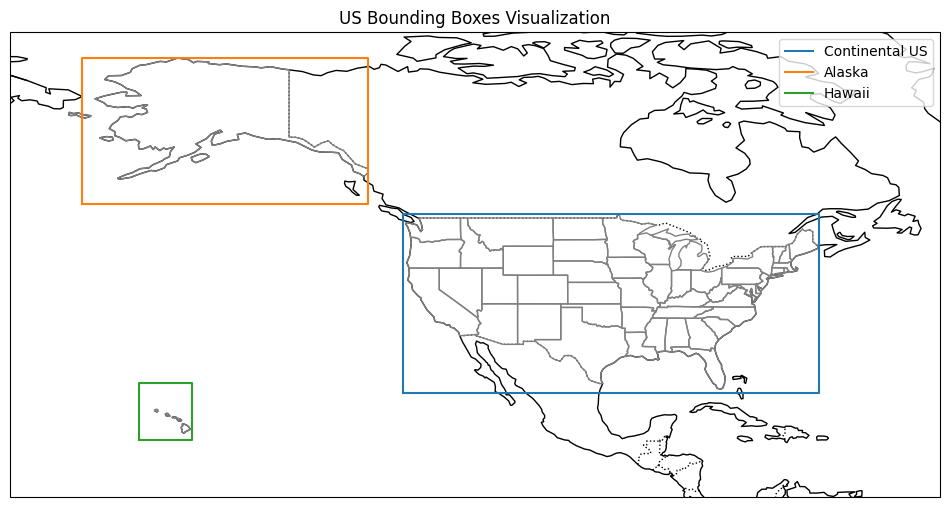

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-180, -50, 10, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray')

bounding_boxes = {
    "Continental US": [[24.5, 49.5], [-125.0, -66.95]],
    "Alaska": [[51.0, 71.4], [-170.0, -129.9]], 
    "Hawaii": [[17.9, 26], [-162.0, -154.5]]
}

for region, ((lat_min, lat_max), (lon_min, lon_max)) in bounding_boxes.items():
    lats = [lat_min, lat_max, lat_max, lat_min, lat_min]
    lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), label=region)

ax.legend()
plt.title("US Bounding Boxes Visualization")
plt.show()


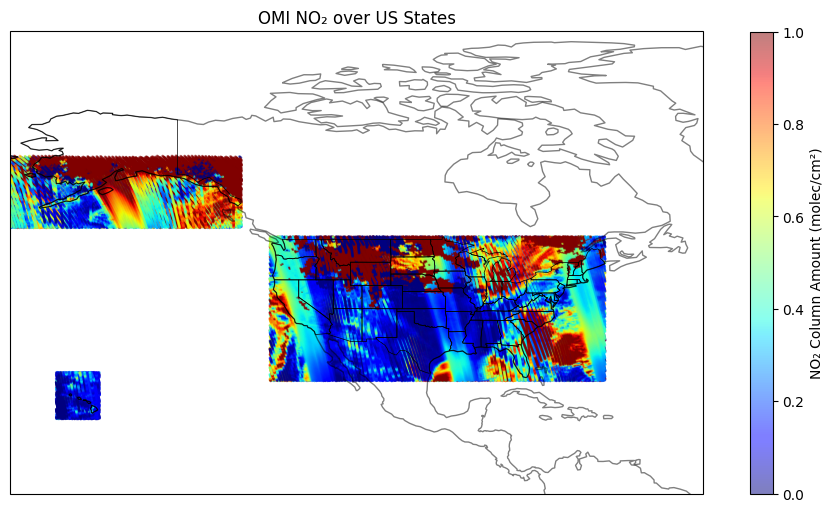

In [12]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -50, 5, 85], crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
scatter = ax.scatter(global_longitude, global_latitude, c=global_cloudFraction, s=1, cmap='jet', transform=ccrs.PlateCarree(), alpha=0.5)
plt.colorbar(scatter, label='NO₂ Column Amount (molec/cm²)', orientation='vertical')
plt.title('OMI NO₂ over US States')
plt.show()

Perfect. Our bounding box and data filtration logic is valid. Lets process data files one month at a time and export them to not run out of memory.

In [8]:
import random

random.sample(omi_no2_links, 10)

['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/042/OMI-Aura_L2-OMI_MINDS_NO2_2020m0211t1604-o082852_v01-01-2022m0210t053236.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/038/OMI-Aura_L2-OMI_MINDS_NO2_2020m0207t1131-o082791_v01-01-2022m0210t052904.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/207/OMI-Aura_L2-OMI_MINDS_NO2_2021m0726t1505-o090584_v01-01-2022m0210t121032.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/306/OMI-Aura_L2-OMI_MINDS_NO2_2021m1102t2202-o092030_v01-01-2022m0210t134302.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2019/111/OMI-Aura_L2-OMI_MINDS_NO2_2019m0421t1205-o078539_v01-01-2022m0210t024711.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/132/OMI-Aura_L2-OMI_MINDS_NO2_2020m0511t1830-o084164_v01-01-2022m0210t062259.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/290/OMI-Aura_L2-OMI_MINDS_NO2_2018m1017

In [ ]:

def get_s3links_for_selected_date(year: str, month:str) -> list[str]:
    """
    Get the S3 links for a specific year and month.
    """
    month_str = f"{int(month):02d}"
    pattern = re.compile(rf'.*OMI_MINDS_NO2_{year}m{month_str}\d{{2}}t\d{{4}}.*\.nc$')
    files = sorted([file for file in omi_no2_links if pattern.search(file)])
    return files

In [ ]:
def process_data_monthly(year: str, month: str):
    '''
    Read the OMI NO2 data files for a specific month and year from S3 bucket and export it.
    '''
    try:
        omi_no2_links_for_selected_YYYYMM = get_s3links_for_selected_date(year, month)
        
        dfs = []

        for current_file in tqdm(omi_no2_links_for_selected_YYYYMM):
            try:
                with s3_fs.open(current_file, mode="rb") as f:
                    with nc.Dataset("in-memory.nc", memory=f.read()) as dataset:
                        filename = os.path.basename(current_file)
                        date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
                        
                        # Extract data
                        ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
                        cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
                        latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
                        longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
                        corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
                        corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
                        
                        # Create boolean mask
                        boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])
                        
                        # Filter data
                        filtered_data = {
                            "latitude": latitude[boolean_mask],
                            "longitude": longitude[boolean_mask],
                            "ColumnAmountNO2": ColumnAmountNO2[boolean_mask],
                            "cloudFraction": cloudFraction[boolean_mask],
                            "LAT1": corner_latitude[:, 0][boolean_mask],
                            "LAT2": corner_latitude[:, 1][boolean_mask],
                            "LAT3": corner_latitude[:, 2][boolean_mask],
                            "LAT4": corner_latitude[:, 3][boolean_mask],
                            "LON1": corner_longitude[:, 0][boolean_mask],
                            "LON2": corner_longitude[:, 1][boolean_mask],
                            "LON3": corner_longitude[:, 2][boolean_mask],
                            "LON4": corner_longitude[:, 3][boolean_mask],
                            "date": np.repeat(date, np.sum(boolean_mask))
                        }
                        
                        dfs.append(pd.DataFrame(filtered_data))
            
            except Exception as e:
                print(f"Error processing file {current_file}: {str(e)}")
                continue

        if dfs:
            final_df = pd.concat(dfs, ignore_index=True)
            output_path = f"omi_no2_data_{year}_{month}.parquet"
            final_df.dropna(inplace=True)
            final_df.reset_index(drop=True, inplace=True)
            final_df.to_parquet(output_path)
        else:
            print("No valid data processed for the given month.")

        return True 
    except Exception as e:
        print(f"Error processing data for {year}-{month}: {str(e)}")
        return False

In [11]:
from joblib import Parallel, delayed

It is taking roughly 3 minutes to process one month of data. Therefore, I will utilize joblib to parallize this process. This way, I can process data for multiple months simultaneously to reduce the total processing time. Each daily file is ~10 MB and reading though them, filtering exporting month file takes some time. Each exported monthly file is ~30MB.

In [12]:
def proces_data_in_parallel(year_selected: str, num_cores= 6):
    """
    This function will process multiple months in parallel for a given year
    """
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    Parallel(n_jobs=num_cores)(delayed(process_data_monthly)(year, month) for year in [year_selected] for month in months)

In [ ]:
proces_data_in_parallel("2018")
proces_data_in_parallel("2019")
proces_data_in_parallel("2020")

In [13]:
proces_data_in_parallel("2020")

100%|██████████| 414/414 [04:32<00:00,  1.52it/s]


In [14]:
proces_data_in_parallel("2021")

100%|██████████| 432/432 [04:38<00:00,  1.55it/s]


In [15]:
proces_data_in_parallel("2022")

100%|██████████| 409/409 [03:55<00:00,  1.73it/s]


Now that we have exported OMI NO2 daily data for each month, lets combine them all into a single parquet file.

In [3]:
files_path = "Data/NO2/"
files = os.listdir(files_path)
files = [os.path.join(files_path, file) for file in files if file.endswith(".parquet")]
files = sorted(files)

In [4]:
len(files), files[0], files[-1]

(60,
 'Data/NO2/omi_no2_data_2018_01.parquet',
 'Data/NO2/omi_no2_data_2022_12.parquet')

In [5]:
df = pd.DataFrame()
for file in tqdm(files):
    df_temp = pd.read_parquet(file)
    df = pd.concat([df, df_temp], ignore_index=True)

100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


In [6]:
df.to_parquet("OMI_NO2_US_2018_2022_COMBINED.parquet")

I quickly used pandas to concat and export the data, which is ~2GB. I could have definately used PySpark here but it wouldn't mean anything. It would have, in fact, been slower than pandas as there would be unnecessary overhead for such a simpler task.

In [8]:
NO2_DF = spark.read.parquet("Data/NO2/OMI_NO2_US_2018_2022_COMBINED.parquet")

In [10]:
NO2_DF.show(10)

+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| latitude| longitude|ColumnAmountNO2|     cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|     date|
+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| 40.26102|  -66.9704|  2.14097046E15|             0.706|39.8134|40.4608|40.6886|40.0696|-67.7036|-66.0866|-66.2213|-67.8613|2018m0101|
| 40.37128| -67.03718|  2.49873493E15|             0.737|39.9231|40.5719|40.7996|40.1791|-67.7709|-66.1521|-66.2873|-67.9292|2018m0101|
|40.481525|-67.104126|  2.08931852E15|             0.739|40.0328|40.6829|40.9105|40.2886|-67.8385|-66.2179|-66.3535|-67.9971|2018m0101|
|40.591774| -67.17118|  1.86005531E15|             0.717|40.1422|40.7938|41.0213| 40.398|-67.9063|-66.2838|-66.4199|-68.0655|2018m0101|
|  40.7019|-67.238594|  2.01618274E15|0.69600000

Here, latitude, longitude and their corner cordinates are geographical information that can be used to perform spatial analysis. ColumnAmountNO2 is the OMI NO2 vertical column density whereas cloudFraction refers to the percentage/fraction of sky covered with clouds at the specific cordinates. If the value of cloud fraction is large, the OMI instrument's NO2 column values will not be accurate as cloud reflects sunlight and the measurement become inaacurate. Therefore, we will later only use data where cloud fraction is less than 0.5. The higher the threshold we set, the more data we loose. 

# 3. Preparing Asthma Data From CDC (County Level)

We can get County Level Asthma dataset from CDC's PLACES portal. These are the links to the datasets that I downlaoded:

1. 2022: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2024-releas/i46a-9kgh/about_data
2. 2021: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2023-releas/7cmc-7y5g/about_data
3. 2020: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2022-releas/xyst-f73f/about_data
4. 2019: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2021-releas/kmvs-jkvx/about_data
5. 2018: https://data.cdc.gov/500-Cities-Places/PLACES-County-Data-GIS-Friendly-Format-2020-releas/mssc-ksj7/about_data

Unfortunately, the latest dataset that I could find from CDC for Asthma (at county level) was for 2022. 

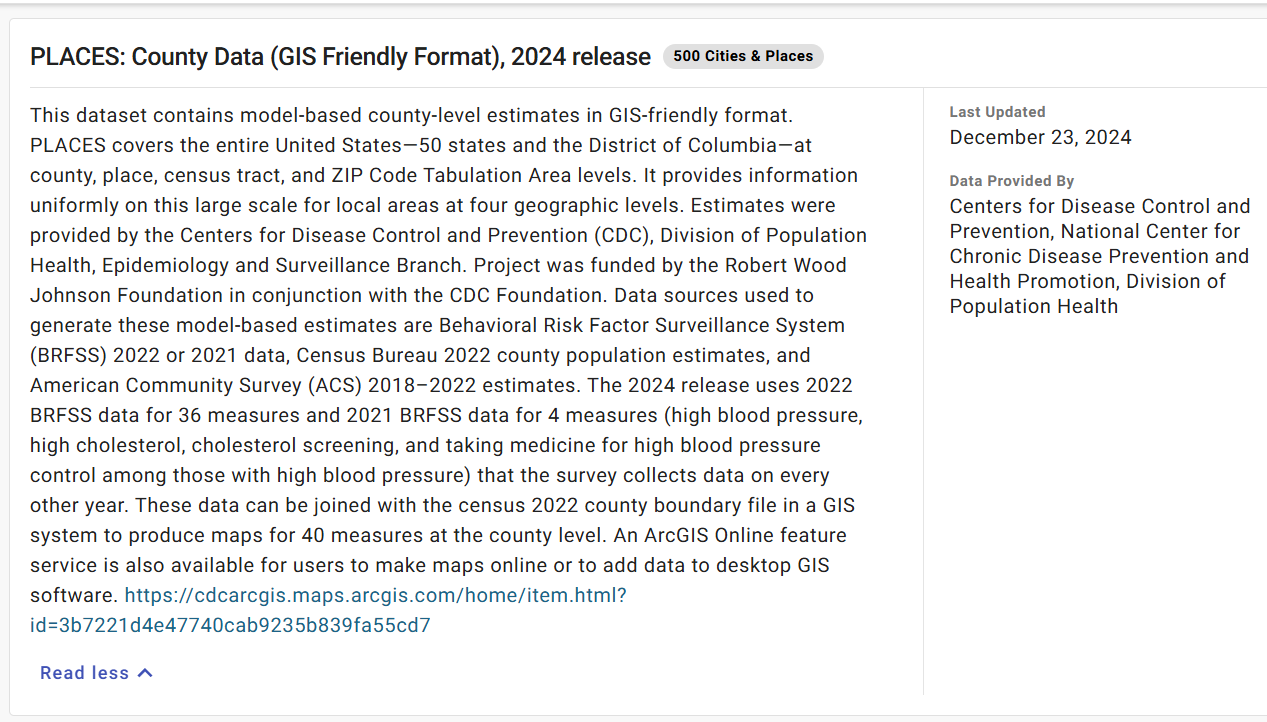

This is the CDC Asthma data for 2022 at county level. It also contains several other parameters that are of interest to us. I will load the data into spark, do preprocessing and export it as a new csv file for further analysis.

In [8]:
cdc_df = spark.read.csv(r"Data\Health_Data\CDC_Data_CountyLevel\2018.csv", header=True, inferSchema=True)

In [9]:
cdc_df.show(5)

+---------+---------+----------+----------+---------------+-----------------+-----------------+---------------+---------------+-------------------+-------------------+-----------------+-----------------+---------------+---------------+-------------+-------------+----------------+----------------+--------------+--------------+---------------+---------------+-------------+-------------+----------------+----------------+--------------+--------------+-----------------+-----------------+---------------+---------------+------------------+------------------+----------------+----------------+-------------+-------------+-----------+------------+-----------------+-----------------+---------------+---------------+--------------------+--------------------+------------------+------------------+----------------------+----------------------+--------------------+--------------------+--------------+--------------+------------+------------+---------------+---------------+-------------+-------------+----

The first few columns are state and county information, which will join with US county shapefiles. Then, we can do spatial analysis as we will have county boundaries. The other columns are essentially of 4 types:

1. ACCESS2_CrudePrev
2. ACCESS2_Crude95CI
3. ACCESS2_AdjPrev
4. ACCESS2_Adj95CI

The first column is the Model-based estimate for crude prevalence of current lack of health insurance among adults aged 18-64 years, 2022. Simialrly, the second, third and fourth are Estimated confidence interval for crude prevalence of lack of health insurance among adults aged 18-64 years, Model-based estimate for age-adjusted prevalence of lack of health insurance among adults aged 18-64 years, 2022, and Estimated confidence interval for age-adjusted prevalence of lack of health insurance among adults aged 18-64 years.

The same applies for rest of the column. If we look at the columns, we can see that we have data for Arthritis, and other interesting parameters like number of people with drinking habits, number of people with diabetes diagnosed etc. Lets extract the Asthma columns for now.

These are the relevant Asthma columns: 

CASTHMA_CrudePrev refers to `Model-based estimate for crude prevalence of current asthma among adults, 2022`.

CASTHMA_Crude95CI refers to `Estimated confidence interval for crude prevalence of current asthma among adults`.

CASTHMA_AdjPrev refers to `Model-based estimate for age-adjusted prevalence of current asthma among adults, 2022`.

CASTHMA_Adj95CI refers to `Estimated confidence interval for age-adjusted prevalence of current asthma among adults`.


For our use case, both crude prevalance and age-adjusted prevalence can be relevant. If we are directly comparing based on different demographic groups with respect to age, the age-adjusted values might be helpful. Whereas, the crude prevalance can help understand the raw burden of Asthma.

Similarly, I also added columns for other paramerters like chronic obstructive pulmonary disease among adults, coronary heart disease, and high blood pressure prevalance among adults.

In [ ]:
cdc_df = cdc_df.withColumn("Year", lit(2018))

In [11]:
relevant_columns = [
    "Year",
    "StateAbbr",
    "StateDesc",
    "CountyName",
    "CountyFIPS",
    "TotalPopulation",
    "CASTHMA_CrudePrev",
    "CASTHMA_AdjPrev",
    "COPD_CrudePrev",
    "COPD_AdjPrev",
    "CHD_CrudePrev",
    "CHD_AdjPrev",    
]

In [12]:
# selecting only relevant columns
cdc_df = cdc_df.select(relevant_columns)
cdc_df.show(5)

+----+---------+---------+----------+----------+---------------+-----------------+---------------+--------------+------------+-------------+-----------+
|Year|StateAbbr|StateDesc|CountyName|CountyFIPS|TotalPopulation|CASTHMA_CrudePrev|CASTHMA_AdjPrev|COPD_CrudePrev|COPD_AdjPrev|CHD_CrudePrev|CHD_AdjPrev|
+----+---------+---------+----------+----------+---------------+-----------------+---------------+--------------+------------+-------------+-----------+
|2018|       AL|  Alabama|   Autauga|      1001|          55601|             10.2|           10.2|           8.6|         7.7|          7.9|        6.9|
|2018|       AL|  Alabama|   Baldwin|      1003|         218022|              9.5|            9.6|           8.6|         7.1|          7.8|        6.0|
|2018|       AL|  Alabama|   Barbour|      1005|          24881|             11.6|           11.7|          12.1|        10.5|         11.0|        9.0|
|2018|       AL|  Alabama|      Bibb|      1007|          22400|             10.3|

In [13]:
remaining_CDC_files= os.listdir("Data/Health_Data/CDC_Data_CountyLevel")
remaining_CDC_files = [os.path.join("Data/Health_Data/CDC_Data_CountyLevel", file) for file in remaining_CDC_files if file.endswith(".csv")]
remaining_CDC_files = sorted(remaining_CDC_files)[1:] # we already read for 2018
remaining_CDC_files

['Data/Health_Data/CDC_Data_CountyLevel\\2019.csv',
 'Data/Health_Data/CDC_Data_CountyLevel\\2020.csv',
 'Data/Health_Data/CDC_Data_CountyLevel\\2021.csv',
 'Data/Health_Data/CDC_Data_CountyLevel\\2022.csv']

In [14]:
# concatenating PySpark dataframes
for file in tqdm(remaining_CDC_files):
    year = os.path.basename(file).split(".")[0]
    df_temp = spark.read.csv(file, header=True, inferSchema=True)
    df_temp = df_temp.withColumn("Year", lit(year))
    df_temp = df_temp.select(relevant_columns)
    cdc_df = cdc_df.union(df_temp) # same as pd.concat([df1, df2])

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


In [15]:
cdc_df.show(10)

+----+---------+---------+----------+----------+---------------+-----------------+---------------+--------------+------------+-------------+-----------+
|Year|StateAbbr|StateDesc|CountyName|CountyFIPS|TotalPopulation|CASTHMA_CrudePrev|CASTHMA_AdjPrev|COPD_CrudePrev|COPD_AdjPrev|CHD_CrudePrev|CHD_AdjPrev|
+----+---------+---------+----------+----------+---------------+-----------------+---------------+--------------+------------+-------------+-----------+
|2018|       AL|  Alabama|   Autauga|      1001|          55601|             10.2|           10.2|           8.6|         7.7|          7.9|        6.9|
|2018|       AL|  Alabama|   Baldwin|      1003|         218022|              9.5|            9.6|           8.6|         7.1|          7.8|        6.0|
|2018|       AL|  Alabama|   Barbour|      1005|          24881|             11.6|           11.7|          12.1|        10.5|         11.0|        9.0|
|2018|       AL|  Alabama|      Bibb|      1007|          22400|             10.3|

In [16]:
number_of_rows_per_year = cdc_df.groupby("Year").count().show()
number_of_rows_per_year

+----+-----+
|Year|count|
+----+-----+
|2018| 3142|
|2019| 3142|
|2020| 3143|
|2021| 3143|
|2022| 3144|
+----+-----+



In [27]:
%%time

# exporting the spark dataframe to parquet to reuse later as we don;t need to do data processing every single time we run the notebook
cdc_df.toPandas().to_parquet("Data/Health_Data/CDC_2018_2022.parquet")

CPU times: total: 188 ms
Wall time: 1.11 s


If you look at the rows, we see number of samples per year. There are 3144 counties and equivalent regions in US. Each row in the dataframe is a value for Asthma and other parameters for a county.

<b> County Level data is good. However, directly comparing county level NO2 pollution with Asthma cases might not yield accurate analysis. This is because some counties are very big and one part of the county can be very polluted but might not have any population whereas the other part might have majority of population. So, it creates an issue of population bias while doing analysis. 

For NO2 comparision with Asthma, I decided to use data at census-tract level. It is even smaller than counties and helps us evaluate relationship at even higher resolution. Thankfully, we can get same health-related datasets for census-tract at census-tract level from CDC.

I will use county level datasets to do analysis but for NO2 vs Asthma, census tract makes most sense. 

You can get census-tract level health datasets from CDC from the following link: https://data.cdc.gov/500-Cities-Places/PLACES-Census-Tract-Data-GIS-Friendly-Format-2024-/yjkw-uj5s/about_data/

In [32]:
'''
The data column format is the same as county. Therefore, I will apply the same logic as before to extract relevant columns.
'''

cdc_censusTract_df = spark.read.csv(r"Data\Health_Data\CDC_Data_CensusTract\CensusTract_2018.csv", header=True, inferSchema=True)

In [34]:
cdc_censusTract_df.show(5)

+---------+---------+----------+----------+----------+---------------+-----------------+-----------------+-------------------+-------------------+---------------+---------------+----------------+----------------+---------------+---------------+----------------+----------------+-----------------+-----------------+------------------+------------------+-------------+-------------+-----------------+-----------------+--------------------+--------------------+----------------------+----------------------+--------------+--------------+---------------+---------------+---------------+---------------+------------------+------------------+----------------+----------------+------------------+------------------+------------------+------------------+----------------+----------------+-------------+-------------+------------------+------------------+---------------+---------------+-----------------+-----------------+---------------+---------------+---------------+---------------+----------------+-----

In [36]:
relevant_columns_for_census_tract = [
    "Year",
    "StateAbbr",
    "StateDesc",
    "CountyName",
    "CountyFIPS",
    "TractFIPS",
    "TotalPopulation",
    "CASTHMA_CrudePrev",
    "COPD_CrudePrev",
    "CHD_CrudePrev",
]

In [38]:
cdc_censusTract_df = cdc_censusTract_df.withColumn("Year", lit(2018))

In [42]:
cdc_censusTract_df = cdc_censusTract_df.select(relevant_columns_for_census_tract)
cdc_censusTract_df.show(5)

+----+---------+---------+----------+----------+----------+---------------+-----------------+--------------+-------------+
|Year|StateAbbr|StateDesc|CountyName|CountyFIPS| TractFIPS|TotalPopulation|CASTHMA_CrudePrev|COPD_CrudePrev|CHD_CrudePrev|
+----+---------+---------+----------+----------+----------+---------------+-----------------+--------------+-------------+
|2018|       AL|  Alabama|   Autauga|      1001|1001020100|           1912|              9.9|           7.7|          6.7|
|2018|       AL|  Alabama|   Autauga|      1001|1001020200|           2170|             11.5|           8.2|          6.5|
|2018|       AL|  Alabama|   Autauga|      1001|1001020300|           3373|             10.6|           8.5|          7.2|
|2018|       AL|  Alabama|   Autauga|      1001|1001020400|           4386|              9.3|           7.7|          7.6|
|2018|       AL|  Alabama|   Autauga|      1001|1001020500|          10766|              9.5|           6.2|          5.7|
+----+---------+

In [39]:
remaining_CDC_files= os.listdir("Data/Health_Data/CDC_Data_CensusTract")
remaining_CDC_files = [os.path.join("Data/Health_Data/CDC_Data_CensusTract", file) for file in remaining_CDC_files if file.endswith(".csv")]
remaining_CDC_files = sorted(remaining_CDC_files)[1:] # we already read for 2018
remaining_CDC_files

['Data/Health_Data/CDC_Data_CensusTract\\CensusTract_2019.csv',
 'Data/Health_Data/CDC_Data_CensusTract\\CensusTract_2020.csv',
 'Data/Health_Data/CDC_Data_CensusTract\\CensusTract_2021.csv',
 'Data/Health_Data/CDC_Data_CensusTract\\CensusTract_2022.csv']

In [43]:
# concatenating PySpark dataframes
for file in tqdm(remaining_CDC_files):
    year = os.path.basename(file).split(".")[0]
    df_temp = spark.read.csv(file, header=True, inferSchema=True)
    df_temp = df_temp.withColumn("Year", lit(year))
    df_temp = df_temp.select(relevant_columns_for_census_tract)
    cdc_censusTract_df = cdc_censusTract_df.union(df_temp) # same as pd.concat([df1, df2])

100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


In [45]:
cdc_censusTract_df.show(10)

+----+---------+---------+----------+----------+----------+---------------+-----------------+--------------+-------------+
|Year|StateAbbr|StateDesc|CountyName|CountyFIPS| TractFIPS|TotalPopulation|CASTHMA_CrudePrev|COPD_CrudePrev|CHD_CrudePrev|
+----+---------+---------+----------+----------+----------+---------------+-----------------+--------------+-------------+
|2018|       AL|  Alabama|   Autauga|      1001|1001020100|           1912|              9.9|           7.7|          6.7|
|2018|       AL|  Alabama|   Autauga|      1001|1001020200|           2170|             11.5|           8.2|          6.5|
|2018|       AL|  Alabama|   Autauga|      1001|1001020300|           3373|             10.6|           8.5|          7.2|
|2018|       AL|  Alabama|   Autauga|      1001|1001020400|           4386|              9.3|           7.7|          7.6|
|2018|       AL|  Alabama|   Autauga|      1001|1001020500|          10766|              9.5|           6.2|          5.7|
|2018|       AL|

In [46]:
number_of_rows_per_year = cdc_censusTract_df.groupby("Year").count().show()
number_of_rows_per_year

+----------------+-----+
|            Year|count|
+----------------+-----+
|            2018|72337|
|CensusTract_2019|72337|
|CensusTract_2020|72337|
|CensusTract_2021|72337|
|CensusTract_2022|83522|
+----------------+-----+



In [47]:
%%time

# exporting the spark dataframe to parquet to reuse later as we don;t need to do data processing every single time we run the notebook
cdc_censusTract_df.toPandas().to_parquet("Data/Health_Data/CDC_CensusTract_2018_2022.parquet")

CPU times: total: 2.02 s
Wall time: 5.69 s


# 4. Preparing Vectorized Boundary Layers (Shapefiles) for US.

In [65]:
regions_to_exclude = [
    "Commonwealth of the Northern Mariana Islands",
    "Alaska",
    "Hawaii",
    "United States Virgin Islands",
    "Puerto Rico",
    "Guam",
    "American Samoa",
]

In [66]:
import geopandas as gpd

us_state_boundary = gpd.read_file(r"Data\US_SHAPEFILES\State_Boundary\us-state-boundaries.shp")
us_state_boundary.rename(columns={"state": "STATEFP", "name":"STATE_NAME"}, inplace=True)
us_state_boundary = us_state_boundary[~us_state_boundary.STATE_NAME.isin(regions_to_exclude)]
us_state_boundary = us_state_boundary[["STATE_NAME", "STATEFP", "geometry"]]
us_state_boundary = us_state_boundary.to_crs("EPSG:4326")

In [67]:
us_county_boundary = gpd.read_file(r"Data\US_SHAPEFILES\County_Boundary\cb_2018_us_county_500k.shp")
us_county_boundary = us_county_boundary[us_county_boundary.STATEFP.isin(us_state_boundary.STATEFP.unique())]
us_county_boundary.rename(columns={"NAME": "COUNTY_NAME"}, inplace=True)
us_county_boundary = us_county_boundary[["STATEFP", "COUNTYFP", "COUNTY_NAME", "geometry"]]
us_county_boundary = us_county_boundary.to_crs("EPSG:4326")

us_county_boundary = us_state_boundary[["STATEFP", "STATE_NAME"]].merge(us_county_boundary, on="STATEFP", how="right")
us_county_boundary = us_county_boundary.set_geometry("geometry")
us_county_boundary.reset_index(drop=True, inplace=True)
us_county_boundary["ID"] = range(1, len(us_county_boundary) + 1)
us_county_boundary.COUNTYFP = us_county_boundary.COUNTYFP.astype(int)

In [68]:
us_census_tract_boundary = gpd.read_file(r"Data\US_SHAPEFILES\Census_Tract\cb_2019_us_tract_500k.shp")
us_census_tract_boundary = us_census_tract_boundary[us_census_tract_boundary.STATEFP.isin(us_state_boundary.STATEFP.unique())]
us_census_tract_boundary = us_census_tract_boundary[["STATEFP", "COUNTYFP", "geometry"]]
us_census_tract_boundary = us_census_tract_boundary.to_crs("EPSG:4326")
us_census_tract_boundary.COUNTYFP = us_census_tract_boundary.COUNTYFP.astype(int)

# bring in county and state names for each census tract
us_census_tract_boundary_with_names = us_census_tract_boundary.merge(
    us_county_boundary[['STATEFP', 'COUNTYFP', 'STATE_NAME', 'COUNTY_NAME']],
    on=['STATEFP', 'COUNTYFP'],
    how='left'
)

us_census_tract_boundary_with_names.reset_index(drop=True, inplace=True)
us_census_tract_boundary["CensusTractID"] = range(1, len(us_census_tract_boundary) + 1)

In [69]:
US_COUNTRY_BOUNDARY = us_state_boundary.dissolve()[["geometry"]]

In [70]:
us_county_boundary.head()

,STATEFP,STATE_NAME,COUNTYFP,COUNTY_NAME,geometry,ID
0,21,Kentucky,7,Ballard,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530...",1
1,21,Kentucky,17,Bourbon,"POLYGON ((-84.44266 38.28323, -84.44113 38.283...",2
2,21,Kentucky,31,Butler,"POLYGON ((-86.94486 37.0734, -86.94346 37.0748...",3
3,21,Kentucky,65,Estill,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461...",4
4,21,Kentucky,69,Fleming,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",5


In [71]:
us_census_tract_boundary

,STATEFP,COUNTYFP,geometry,CensusTractID
0,34,5,"POLYGON ((-74.90801 40.0325, -74.90496 40.0364...",1
1,39,153,"POLYGON ((-81.51807 41.05957, -81.51805 41.062...",2
2,36,71,"POLYGON ((-74.02226 41.49281, -74.0218 41.4967...",3
3,06,13,"POLYGON ((-122.32697 37.93502, -122.32611 37.9...",4
4,48,113,"POLYGON ((-96.76903 32.94655, -96.76899 32.950...",5
...,...,...,...,...
73862,39,113,"POLYGON ((-84.21066 39.58867, -84.20976 39.597...",72329
73863,48,245,"POLYGON ((-94.28353 29.88008, -94.2623 29.9104...",72330
73864,01,73,"POLYGON ((-87.16295 33.49311, -87.16185 33.495...",72331
73866,06,81,"POLYGON ((-122.27898 37.54565, -122.2759 37.54...",72332


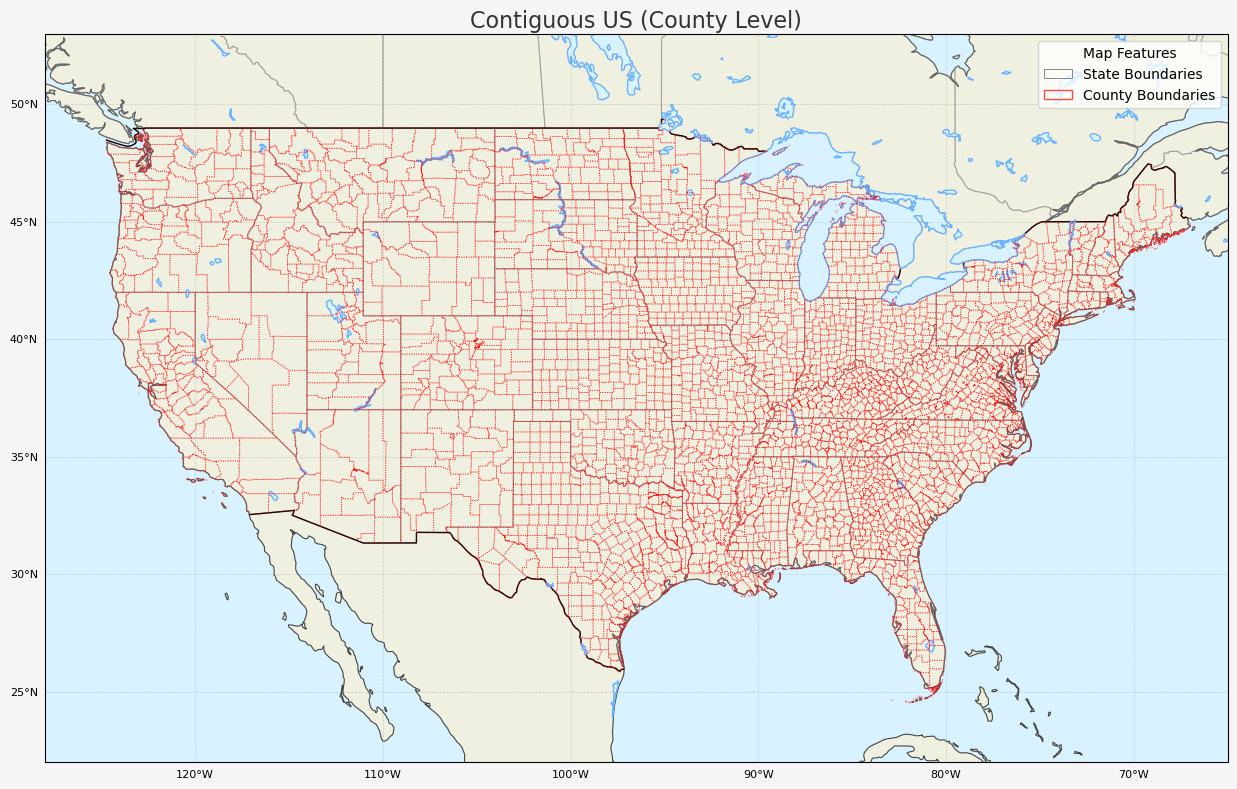

In [27]:
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={"projection": ccrs.PlateCarree()}, facecolor='#f5f5f5')  
ax.set_extent([-128, -65, 22, 53], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='#f0f0e0', edgecolor='none')
ax.add_feature(cfeature.OCEAN, facecolor='#d8f3ff')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='#444444')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='#888888', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.LAKES, facecolor='#d8f3ff', edgecolor='#6bb2ff')
us_county_boundary.geometry.boundary.plot(ax=ax, color='red', linewidth=0.65, alpha=0.7, linestyle=":")
county_patch = mpatches.Patch(label='County Boundaries', alpha=0.7, fill=False, edgecolor="red")
state_patch = mpatches.Patch(facecolor='none', edgecolor='#888888', linewidth=0.7, label='State Boundaries', fill=False)
legend = ax.legend(handles=[state_patch, county_patch],  loc='upper right', frameon=True, framealpha=0.8, title='Map Features')
plt.title("Contiguous US (County Level)", fontsize=16, pad=5, color='#333333')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
plt.tight_layout()
plt.show()

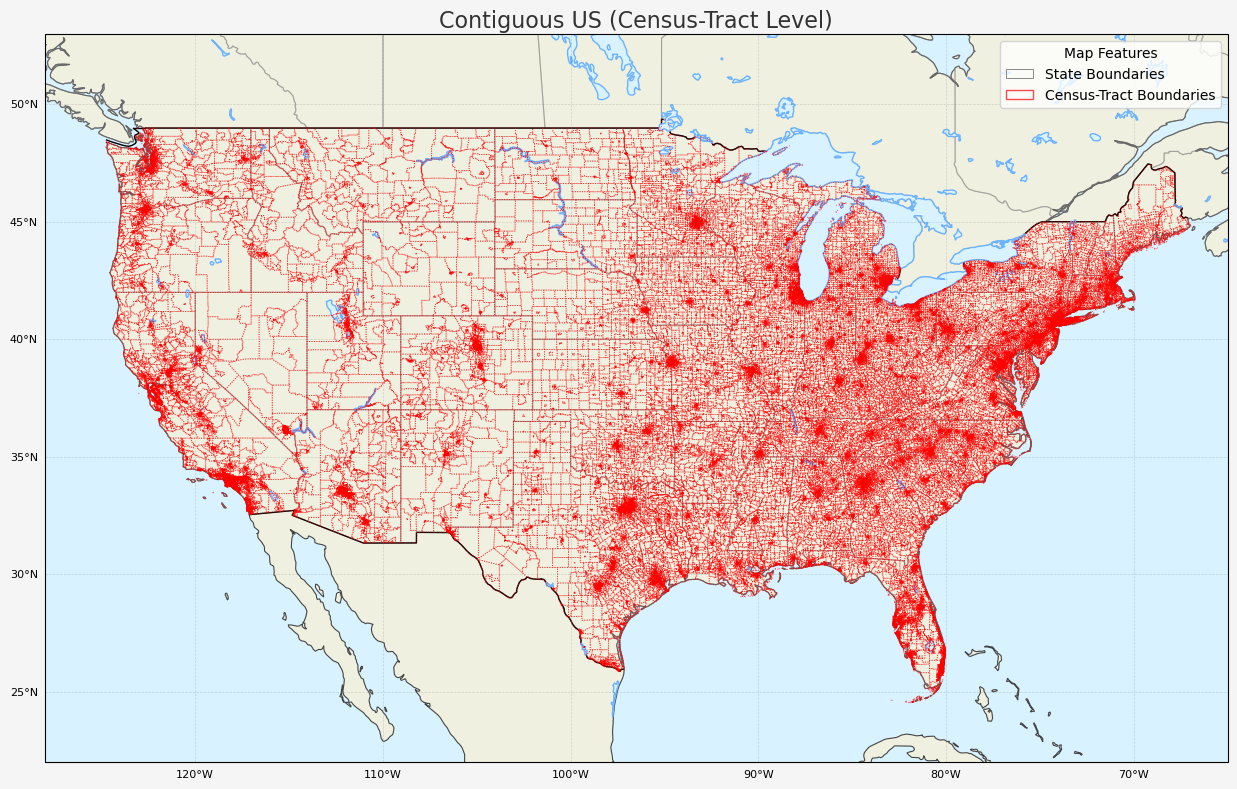

In [28]:
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={"projection": ccrs.PlateCarree()}, facecolor='#f5f5f5')  
ax.set_extent([-128, -65, 22, 53], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='#f0f0e0', edgecolor='none')
ax.add_feature(cfeature.OCEAN, facecolor='#d8f3ff')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='#444444')
ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='#888888', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.LAKES, facecolor='#d8f3ff', edgecolor='#6bb2ff')
us_census_tract_boundary.geometry.boundary.plot(ax=ax, color='red', linewidth=0.65, alpha=0.7, linestyle=":")
censustract_patch = mpatches.Patch(label='Census-Tract Boundaries', alpha=0.7, fill=False, edgecolor="red")
state_patch = mpatches.Patch(facecolor='none', edgecolor='#888888', linewidth=0.7, label='State Boundaries', fill=False)
legend = ax.legend(handles=[state_patch, censustract_patch],  loc='upper right', frameon=True, framealpha=0.8, title='Map Features')
plt.title("Contiguous US (Census-Tract Level)", fontsize=16, pad=5, color='#333333')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
plt.tight_layout()
plt.show()

In [72]:
cdc_df = pd.read_parquet("Data/Health_Data/CDC_2018_2022.parquet")
cdc_df = cdc_df[cdc_df["Year"] == '2022']
cdc_df.rename(columns = {"StateDesc": "STATE_NAME", "CountyName": "COUNTY_NAME"}, inplace = True)
cdc_df = cdc_df[["STATE_NAME", "COUNTY_NAME", "TotalPopulation","CASTHMA_CrudePrev", "CASTHMA_AdjPrev", "COPD_CrudePrev", "COPD_AdjPrev", "CHD_CrudePrev", "CHD_AdjPrev"]]
cdc_df.reset_index(drop=True, inplace=True)
cdc_df.rename(columns={"CountyFIPS": "COUNTYFP"}, inplace=True)

In [73]:
no2_df = pd.read_parquet("Data/NO2/2018_data_only.parquet")
no2_df = no2_df[no2_df["cloudFraction"] <= 0.4]
no2_df = no2_df[no2_df["ColumnAmountNO2"] > 0]

In [74]:
no2_df["geometry"] = gpd.points_from_xy(no2_df["longitude"], no2_df["latitude"])
no2_df = gpd.GeoDataFrame(no2_df, geometry="geometry", crs="EPSG:4326")

In [75]:
dask_df = dask_geopandas.from_geopandas(no2_df, npartitions=4)
fishnet_x_dask = dask_geopandas.from_geopandas(us_county_boundary, npartitions=4)

In [76]:
%%time

result = dask_df.sjoin(fishnet_x_dask, predicate ='within').compute()

CPU times: total: 6.45 s
Wall time: 9.73 s


In [77]:
def get_ordered_dict(dx, IDs):
    for id_ in IDs:
        if id_ not in dx.keys():
            dx[id_] = np.nan
    
    dict1 = dict(OrderedDict(sorted(dx.items())))
    return np.array(list(dict1.values()))

In [78]:
us_county_boundary["NO2"] = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), us_county_boundary['ID'])

In [80]:
us_county_boundary.head()

,STATEFP,STATE_NAME,COUNTYFP,COUNTY_NAME,geometry,ID,NO2
0,21,Kentucky,7,Ballard,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530...",1,4.612516e+15
1,21,Kentucky,17,Bourbon,"POLYGON ((-84.44266 38.28323, -84.44113 38.283...",2,4.668639e+15
2,21,Kentucky,31,Butler,"POLYGON ((-86.94486 37.0734, -86.94346 37.0748...",3,5.411017e+15
3,21,Kentucky,65,Estill,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461...",4,5.069253e+15
4,21,Kentucky,69,Fleming,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",5,4.681330e+15


In [79]:
cdc_df.head()

,STATE_NAME,COUNTY_NAME,TotalPopulation,CASTHMA_CrudePrev,CASTHMA_AdjPrev,COPD_CrudePrev,COPD_AdjPrev,CHD_CrudePrev,CHD_AdjPrev
0,South Dakota,Yankton,23373,9.1,9.2,6.3,5.2,7.7,5.8
1,Oklahoma,Haskell,11641,13.2,13.5,11.7,10.0,10.7,8.2
2,Illinois,Lake,709150,9.1,9.1,5.9,5.3,6.2,5.4
3,Kansas,Atchison,16108,11.0,11.2,8.3,7.6,7.7,6.4
4,Alaska,Anchorage,287145,10.2,10.2,4.7,4.6,5.1,5.1


In [82]:
us_county_boundary = us_county_boundary.merge(cdc_df, on = ["STATE_NAME", "COUNTY_NAME"], how = "left")

In [ ]:
us_county_boundary["area"] = 

,ID,STATEFP,COUNTYFP,COUNTY_NAME,STATE_NAME,TotalPopulation,NO2,CASTHMA_CrudePrev,CASTHMA_AdjPrev,COPD_CrudePrev,COPD_AdjPrev,CHD_CrudePrev,CHD_AdjPrev,geometry
0,1,21,7,Ballard,Kentucky,7650.0,4.612516e+15,11.5,11.6,12.4,10.3,9.7,7.3,"POLYGON ((-89.18137 37.0463, -89.17938 37.0530..."
1,2,21,17,Bourbon,Kentucky,20093.0,4.668639e+15,11.2,11.2,11.7,9.6,9.4,7.1,"POLYGON ((-84.44266 38.28323, -84.44113 38.283..."
2,3,21,31,Butler,Kentucky,12295.0,5.411017e+15,11.6,11.7,12.8,10.8,9.7,7.7,"POLYGON ((-86.94486 37.0734, -86.94346 37.0748..."
3,4,21,65,Estill,Kentucky,14044.0,5.069253e+15,11.8,11.8,14.6,12.1,10.3,8.1,"POLYGON ((-84.12662 37.6454, -84.12483 37.6461..."
4,5,21,69,Fleming,Kentucky,15288.0,4.681330e+15,11.7,11.9,13.2,11.4,9.7,7.8,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115,3104,31,73,Gosper,Nebraska,1808.0,4.118656e+15,9.1,9.4,6.9,5.5,8.3,5.9,"POLYGON ((-100.09509 40.43865, -100.08937 40.4..."
3116,3105,39,75,Holmes,Ohio,44390.0,5.040416e+15,12.3,12.4,12.6,11.8,8.8,7.9,"POLYGON ((-82.22066 40.66758, -82.19327 40.667..."
3117,3106,48,171,Gillespie,Texas,27477.0,4.089981e+15,9.5,9.8,9.0,6.5,9.5,5.8,"POLYGON ((-99.304 30.49983, -99.28235 30.49967..."
3118,3107,55,79,Milwaukee,Wisconsin,918661.0,6.961680e+15,11.7,11.7,6.6,6.3,6.0,5.7,"POLYGON ((-88.06959 42.86726, -88.06959 42.872..."


In [83]:
us_county_boundary.columns

Index(['STATEFP', 'STATE_NAME', 'COUNTYFP', 'COUNTY_NAME', 'geometry', 'ID',
       'NO2', 'TotalPopulation', 'CASTHMA_CrudePrev', 'CASTHMA_AdjPrev',
       'COPD_CrudePrev', 'COPD_AdjPrev', 'CHD_CrudePrev', 'CHD_AdjPrev'],
      dtype='object')

In [85]:
us_county_boundary = us_county_boundary[["ID", "STATEFP", "COUNTYFP", "COUNTY_NAME", "STATE_NAME", "TotalPopulation", "NO2", 
                                         "CASTHMA_CrudePrev", "CASTHMA_AdjPrev", "COPD_CrudePrev", "COPD_AdjPrev", "CHD_CrudePrev", "CHD_AdjPrev",
                                         "geometry"]]

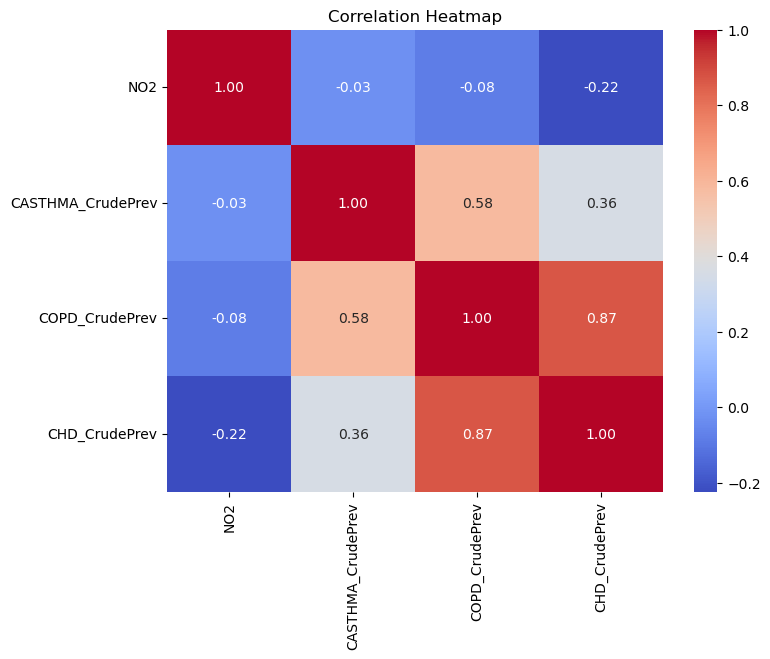

In [93]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = us_county_boundary[["NO2", "CASTHMA_CrudePrev", "COPD_CrudePrev", "CHD_CrudePrev"]].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap")
plt.show()